過去７日間、マグニチュード4.5以上の地震

In [1]:
import pandas as pd
import requests

# API のエンドポイント例
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": "2025-11-04",   # 過去7日間（例）
    "minmagnitude": 4.5,
    "orderby": "time"
}
resp = requests.get(url, params=params)
data_json = resp.json()

# GeoJSON → pandas DataFrame に変換
records = []
for feature in data_json["features"]:
    prop = feature["properties"]
    geom = feature["geometry"]["coordinates"]
    # geom: [longitude, latitude, depth]
    records.append({
        "time": prop["time"],
        "mag": prop["mag"],
        "place": prop["place"],
        "longitude": geom[0],
        "latitude": geom[1],
        "depth": geom[2]
    })
df = pd.DataFrame(records)

# 時刻を人間可読／日本時間に変換
df["time_converted"] = pd.to_datetime(df["time"], unit="ms", utc=True).dt.tz_convert("Asia/Tokyo")


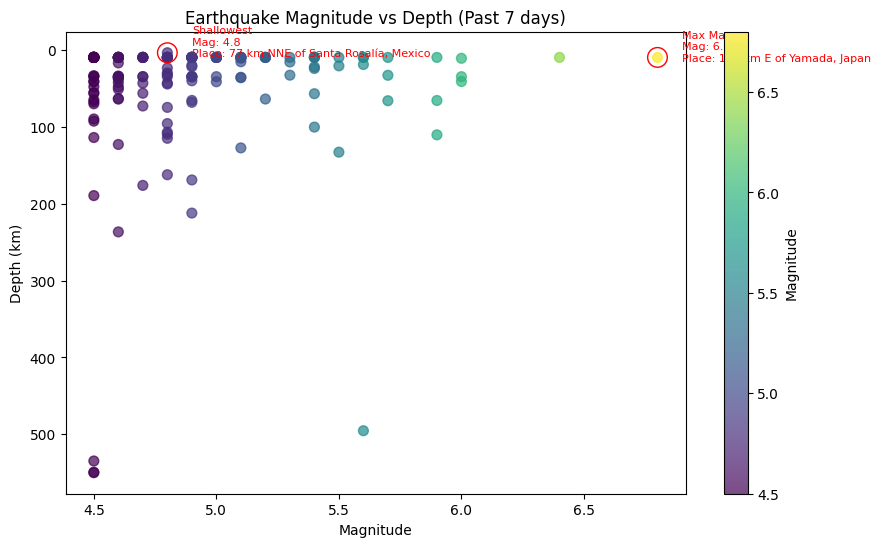

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(df["mag"], df["depth"], alpha=0.7, s=50, c=df["mag"], cmap="viridis")
plt.gca().invert_yaxis()
plt.colorbar(label="Magnitude")
plt.xlabel("Magnitude")
plt.ylabel("Depth (km)")
plt.title("Earthquake Magnitude vs Depth (Past 7 days)")
# 強い地震・浅い地震をハイライト
max_mag_idx = df["mag"].idxmax()
shallow_idx = df["depth"].idxmin()
for idx, label in [(max_mag_idx,"Max Mag"), (shallow_idx,"Shallowest")]:
    plt.scatter(df.loc[idx, "mag"], df.loc[idx, "depth"], s=200, edgecolors='red', facecolors='none')
    plt.text(df.loc[idx, "mag"]+0.1, df.loc[idx, "depth"]+5,
             f"{label}\nMag: {df.loc[idx,'mag']}\nPlace: {df.loc[idx,'place']}",
             fontsize=8, color='red')
plt.show()


C:\Users\yuuuk\AppData\Local\Temp\ipykernel_6616\2543922893.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  counts = df["mag"].resample("4H").count()  # 4時間毎に集計


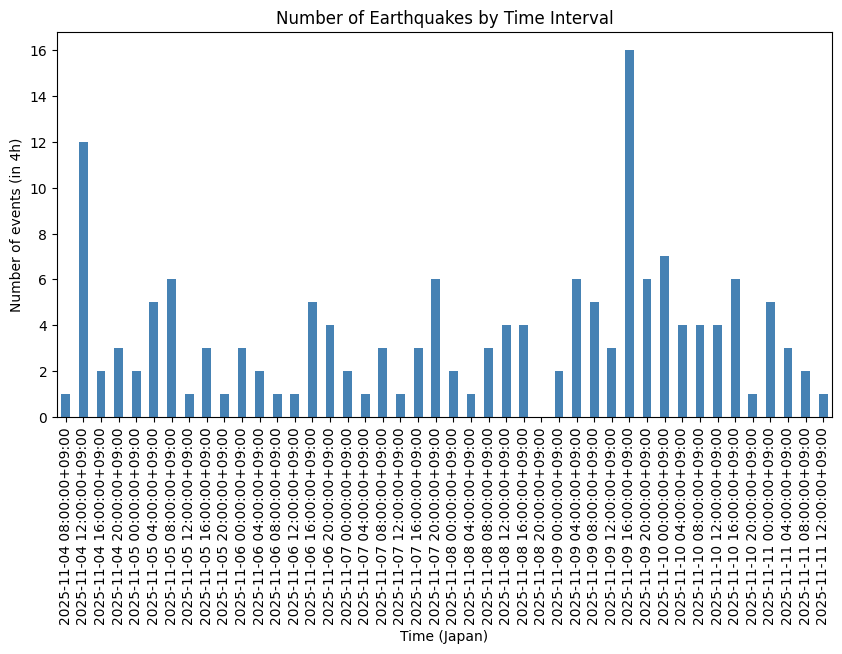

In [3]:
df.set_index("time_converted", inplace=True)
counts = df["mag"].resample("4H").count()  # 4時間毎に集計
plt.figure(figsize=(10,5))
counts.plot(kind="bar", color="steelblue")
plt.xlabel("Time (Japan)")
plt.ylabel("Number of events (in 4h)")
plt.title("Number of Earthquakes by Time Interval")
plt.show()


In [5]:
import pandas as pd
import requests

# --- USGS APIから地震データ取得 ---
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": "2025-11-01",
    "minmagnitude": 4.5,
    "orderby": "time"
}
resp = requests.get(url, params=params)
data_json = resp.json()

# --- GeoJSON → DataFrame ---
records = []
for feature in data_json["features"]:
    prop = feature["properties"]
    geom = feature["geometry"]["coordinates"]
    records.append({
        "time": prop["time"],
        "mag": prop["mag"],
        "place": prop["place"],
        "longitude": geom[0],
        "latitude": geom[1],
        "depth": geom[2]
    })
df = pd.DataFrame(records)

# --- 時刻を変換（日本時間）---
df["time_converted"] = pd.to_datetime(df["time"], unit="ms", utc=True).dt.tz_convert("Asia/Tokyo")

# --- インパクトスコア計算（浅くて大きい地震ほど高スコア）---
df["impact_score"] = df["mag"] * (1 / (df["depth"] + 1))

# --- スコア上位5件を表示 ---
df_sorted = df.sort_values("impact_score", ascending=False)
print(df_sorted.head(5)[["time_converted", "place", "mag", "depth", "impact_score"]])


                      time_converted                               place  mag  \
103 2025-11-07 01:36:09.484000+09:00  77 km NNE of Santa Rosalía, Mexico  4.8   
56  2025-11-09 17:03:37.808000+09:00           126 km E of Yamada, Japan  6.8   
51  2025-11-09 17:54:36.991000+09:00           121 km E of Yamada, Japan  6.4   
54  2025-11-09 17:14:53.100000+09:00           127 km E of Yamada, Japan  5.9   
46  2025-11-09 18:28:23.919000+09:00           134 km E of Miyako, Japan  5.7   

      depth  impact_score  
103   3.908      0.977995  
56   10.000      0.618182  
51   10.000      0.581818  
54   10.000      0.536364  
46   10.000      0.518182  


日本周辺の地震件数: 66 件
                     time_converted                        place  mag   depth  \
73 2025-11-09 17:03:37.808000+09:00    126 km E of Yamada, Japan  6.8  10.000   
68 2025-11-09 17:54:36.991000+09:00    121 km E of Yamada, Japan  6.4  10.000   
71 2025-11-09 17:14:53.100000+09:00    127 km E of Yamada, Japan  5.9  10.000   
63 2025-11-09 18:28:23.919000+09:00    134 km E of Miyako, Japan  5.7  10.000   
29 2025-11-10 12:00:18.358000+09:00  101 km ESE of Yamada, Japan  5.4   9.446   

    impact_score  
73      0.618182  
68      0.581818  
71      0.536364  
63      0.518182  
29      0.516944  


C:\Users\yuuuk\AppData\Local\Temp\ipykernel_6616\3456929388.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japan_df["impact_score"] = japan_df["mag"] * (1 / (japan_df["depth"] + 1))


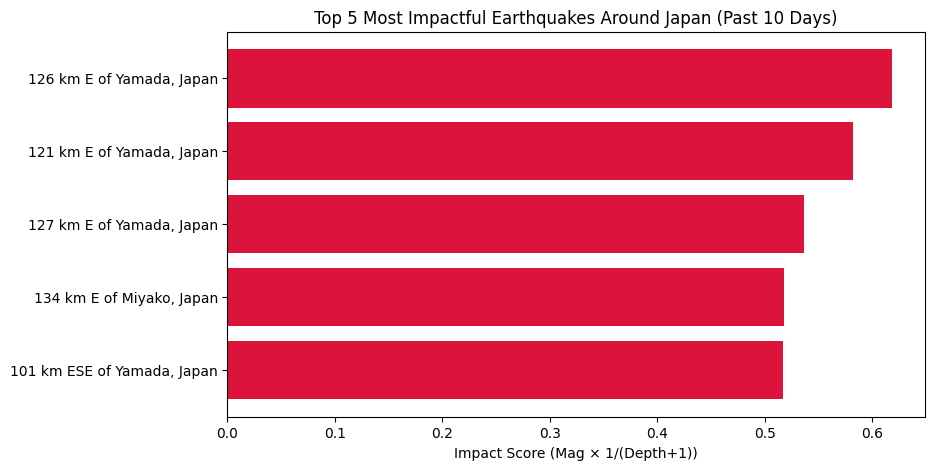

In [6]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

# --- USGS APIから地震データ取得 ---
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": "2025-11-01",  # 過去10日分
    "minmagnitude": 4.0,
    "orderby": "time"
}
resp = requests.get(url, params=params)
data_json = resp.json()

# --- GeoJSON → DataFrame ---
records = []
for feature in data_json["features"]:
    prop = feature["properties"]
    geom = feature["geometry"]["coordinates"]
    records.append({
        "time": prop["time"],
        "mag": prop["mag"],
        "place": prop["place"],
        "longitude": geom[0],
        "latitude": geom[1],
        "depth": geom[2]
    })
df = pd.DataFrame(records)

# --- 日本時間に変換 ---
df["time_converted"] = pd.to_datetime(df["time"], unit="ms", utc=True).dt.tz_convert("Asia/Tokyo")

# --- 日本周辺だけ抽出 ---
# （おおよその範囲：緯度24〜46°, 経度122〜153°）
japan_df = df[(df["latitude"] >= 24) & (df["latitude"] <= 46) &
              (df["longitude"] >= 122) & (df["longitude"] <= 153)]

print(f"日本周辺の地震件数: {len(japan_df)} 件")

# --- インパクトスコア計算 ---
japan_df["impact_score"] = japan_df["mag"] * (1 / (japan_df["depth"] + 1))

# --- スコア上位5件 ---
top5 = japan_df.sort_values("impact_score", ascending=False).head(5)
print(top5[["time_converted", "place", "mag", "depth", "impact_score"]])

# --- グラフ表示 ---
plt.figure(figsize=(9,5))
plt.barh(top5["place"], top5["impact_score"], color="crimson")
plt.xlabel("Impact Score (Mag × 1/(Depth+1))")
plt.title("Top 5 Most Impactful Earthquakes Around Japan (Past 10 Days)")
plt.gca().invert_yaxis()
plt.show()


過去10日間の日本周辺の地震データを分析すると、いくつか興味深い傾向が見えてきます。まず、地震の発生は主に太平洋プレートやフィリピン海プレートの境界付近に集中していて、特に東北沖から伊豆・小笠原諸島、南西諸島沿岸部で活発です。この分布は日本列島が複数のプレートの境界上に位置する特徴を反映しています。次に、マグニチュードと深さの関係では、浅い地震ほど地表への影響が大きく、揺れとして体感されやすいことがわかります。深い地震はマグニチュードが大きくても被害は限定的で、浅発地震の重要性が浮き彫りになります。この結果から、沿岸部を中心に被害リスクの高い地域が特定でき、防災や監視の優先順位付けに活用できるとおもった。